In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
import re,os
import xgboost as xgb
from scipy.stats import skew


/usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [4]:
train = pd.read_csv("/content/Titanic_train.csv")
test = pd.read_csv("/content/Titanic_test.csv")

train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
print('Number of Training Examples = {}'.format(train.shape[0]))
print('Number of Test Examples = {}\n'.format(test.shape[0]))
print('Training X Shape = {}'.format(train.shape))
print('Training y Shape = {}\n'.format(train['Survived'].shape[0]))
print('Test X Shape = {}'.format(test.shape))
print('Test y Shape = {}\n'.format(test.shape[0]))
print(train.columns)
print(test.columns)

Number of Training Examples = 891
Number of Test Examples = 418

Training X Shape = (891, 12)
Training y Shape = 891

Test X Shape = (418, 11)
Test y Shape = 418

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')
Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')


In [6]:
train.sample(15)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
733,734,0,2,"Berriman, Mr. William John",male,23.00,0,0,28425,13.0000,NaN,S
466,467,0,2,"Campbell, Mr. William",male,NaN,0,0,239853,0.0000,NaN,S
254,255,0,3,"Rosblom, Mrs. Viktor (Helena Wilhelmina)",female,41.00,0,2,370129,20.2125,NaN,S
755,756,1,2,"Hamalainen, Master. Viljo",male,0.67,1,1,250649,14.5000,NaN,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.5500,NaN,S
284,285,0,1,"Smith, Mr. Richard William",male,NaN,0,0,113056,26.0000,A19,S
459,460,0,3,"O'Connor, Mr. Maurice",male,NaN,0,0,371060,7.7500,NaN,Q
310,311,1,1,"Hays, Miss. Margaret Bechstein",female,24.00,0,0,11767,83.1583,C54,C
463,464,0,2,"Milling, Mr. Jacob Christian",male,48.00,0,0,234360,13.0000,NaN,S
230,231,1,1,"Harris, Mrs. Henry Birkhardt (Irene Wallach)",female,35.00,1,0,36973,83.4750,C83,S


In [7]:
from sklearn.base import BaseEstimator, TransformerMixin

class ProbabilityEncoder(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.probabilities = None

    def fit(self, X, y=None):
        total_count = X.value_counts().sum()
        self.probabilities = (X.value_counts() / total_count).to_dict()
        return self

    def transform(self, X):
        X_encoded = X.map(self.probabilities)
        return X_encoded

In [9]:
train = pd.read_csv("/content/Titanic_train.csv")
test = pd.read_csv("/content/Titanic_test.csv")
PassengerId = test['PassengerId']

def extract_titles(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""

def clean_and_combine_titles(title):
    # Define a dictionary to map similar titles to a common title
    title_mapping = {
        'Mr': 'Mr', 'Mrs': 'Mrs', 'Miss': 'Miss', 'Master': 'Master', 'Ms': 'Miss', 'Mme': 'Mrs',
        'Mlle': 'Miss', 'Dr': 'Noble', 'Rev': 'Noble', 'Don': 'Noble', 'Major': 'Noble', 'Lady': 'Noble',
        'Sir': 'Noble', 'Col': 'Noble', 'Capt': 'Noble', 'Countess': 'Noble', 'Jonkheer': 'Noble', 'Dona': 'Noble'
    }
#     title2 = title_mapping.get(title, 'Other')
#     title_mapping = {"Mr": 0, "Miss": 1, "Mrs": 2, "Master": 3, "Noble": 4}
    return title_mapping.get(title, 'Other')

def impute_age(row):
    if np.isnan(row['Age']):
        return title_means[row['title']]
    else:
        return row['Age']


data_dict = {"train": train, "test": test}
for key in data_dict.keys():
    data_dict[key]['title'] = data_dict[key]['Name'].apply(extract_titles)
    data_dict[key]['title'] = data_dict[key]['title'].apply(clean_and_combine_titles)
    data_dict[key]['Embarked'] = data_dict[key]['Embarked'].fillna("Other")

    if key == "train":
        pe_title = ProbabilityEncoder()
        pe_embarked = ProbabilityEncoder()
        pe_sex = ProbabilityEncoder()
        data_dict[key]['title'] = pe_title.fit_transform(data_dict[key]['title'])
        data_dict[key]['Embarked'] = pe_embarked.fit_transform(data_dict[key]['Embarked'])
#         data_dict[key]['Sex'] = pe_sex.fit_transform(data_dict[key]['Sex'])
    else:
        data_dict[key]['title'] = pe_title.transform(data_dict[key]['title'])
        data_dict[key]['Embarked'] = pe_embarked.transform(data_dict[key]['Embarked'])
#         data_dict[key]['Sex'] = pe_sex.transform(data_dict[key]['Sex'])

    data_dict[key]['Has_Cabin'] = data_dict[key]["Cabin"].apply(lambda x: 0 if type(x) == float else 1)
    data_dict[key]['FamilySize'] = data_dict[key]['SibSp'] + data_dict[key]['Parch'] + 1
    data_dict[key]['IsAlone'] = 0
    data_dict[key].loc[data_dict[key]['FamilySize'] == 1, 'IsAlone'] = 1
    data_dict[key]['Sex'] = data_dict[key]['Sex'].map({'female': 0, 'male': 1}).astype(int)



full_data = pd.concat([train, test])
title_means = full_data.groupby('title')['Age'].mean()
full_data['Age'] = full_data.apply(impute_age, axis=1)
full_data['Fare'] = full_data['Fare'].fillna(train['Fare'].median())

# bin_edges = [0, 12, 19, 39, 59, 100]
# bin_numerical_codes = [0, 1, 2, 3, 4]

# # Create a new column 'AgeGroupCode' based on age bins
# # full_data['AgeGroupCode'] = pd.cut(full_data['Age'], bins=bin_edges, labels=bin_numerical_codes, include_lowest=True, right=False).astype(int)
# full_data['AgeGroupCode'] = pd.qcut(full_data['Age'], q=10, labels=False)

# # Use qcut to create fare groups
# full_data['FareGroupCode'] = pd.qcut(full_data['Fare'], q=10, labels=False)

full_data.loc[ full_data['Fare'] <= 7.91, 'Fare'] 						        = 0
full_data.loc[(full_data['Fare'] > 7.91) & (full_data['Fare'] <= 14.454), 'Fare'] = 1
full_data.loc[(full_data['Fare'] > 14.454) & (full_data['Fare'] <= 31), 'Fare']   = 2
full_data.loc[ full_data['Fare'] > 31, 'Fare'] 							        = 3
full_data['Fare'] = full_data['Fare'].astype(int)

# Mapping Age
full_data.loc[ full_data['Age'] <= 16, 'Age'] 					       = 0
full_data.loc[(full_data['Age'] > 16) & (full_data['Age'] <= 32), 'Age'] = 1
full_data.loc[(full_data['Age'] > 32) & (full_data['Age'] <= 48), 'Age'] = 2
full_data.loc[(full_data['Age'] > 48) & (full_data['Age'] <= 64), 'Age'] = 3
full_data.loc[ full_data['Age'] > 64, 'Age'] = 4 ;

full_data = full_data.drop(['Cabin', 'SibSp', 'Parch', 'Ticket', 'Name'], axis=1)

In [10]:
full_data

,PassengerId,Survived,Pclass,Sex,Age,Fare,Embarked,title,Has_Cabin,FamilySize,IsAlone
0,1,0.0,3,1,1.0,0,0.722783,0.580247,0,2,0
1,2,1.0,1,0,2.0,3,0.188552,0.141414,1,2,0
2,3,1.0,3,0,1.0,1,0.722783,0.207632,0,1,1
3,4,1.0,1,0,2.0,3,0.722783,0.141414,1,2,0
4,5,0.0,3,1,2.0,1,0.722783,0.580247,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,NaN,3,1,2.0,1,0.722783,0.580247,0,1,1
414,1306,NaN,1,0,2.0,3,0.188552,0.025814,1,1,1
415,1307,NaN,3,1,2.0,0,0.722783,0.580247,0,1,1
416,1308,NaN,3,1,2.0,1,0.722783,0.580247,0,1,1


In [11]:
test_df = full_data[full_data['PassengerId'].isin(PassengerId)]
test_df.drop(["Survived"], axis=1, inplace=True)
X = full_data[~full_data['PassengerId'].isin(PassengerId)]
y = X['Survived']
features = [col for col in X.columns if col != "PassengerId"]

<ipython-input-11-ca0561292d3f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df.drop(["Survived"], axis=1, inplace=True)


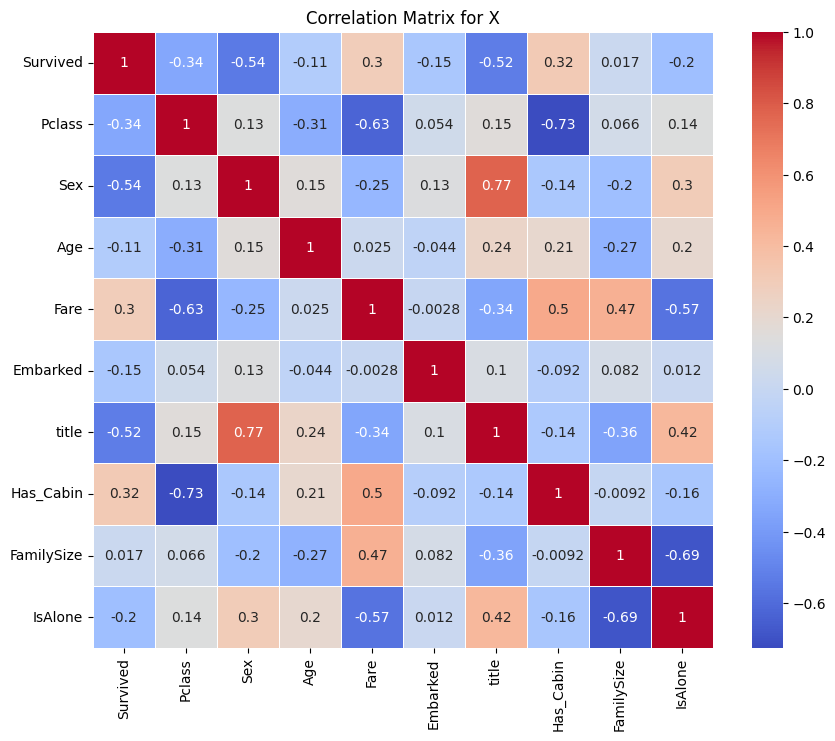

In [12]:
correlation_matrix = X[features].corr()

# Create a heatmap to visualize the correlations
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=.5)
plt.title('Correlation Matrix for X')
plt.show()


Skewness PassengerId: 0.0
Skewness Survived: 0.4777174662568536
Skewness Pclass: -0.6294858816096934
Skewness Sex: -0.6178784065548295
Skewness Age: 0.3020165267946633
Skewness Fare: -0.015066092049346938
Skewness Embarked: -1.0314181232847752
Skewness title: -0.4387181521929237
Skewness Has_Cabin: 1.29019002099093
Skewness FamilySize: 2.7228476726920388
Skewness IsAlone: -0.4197225626974862


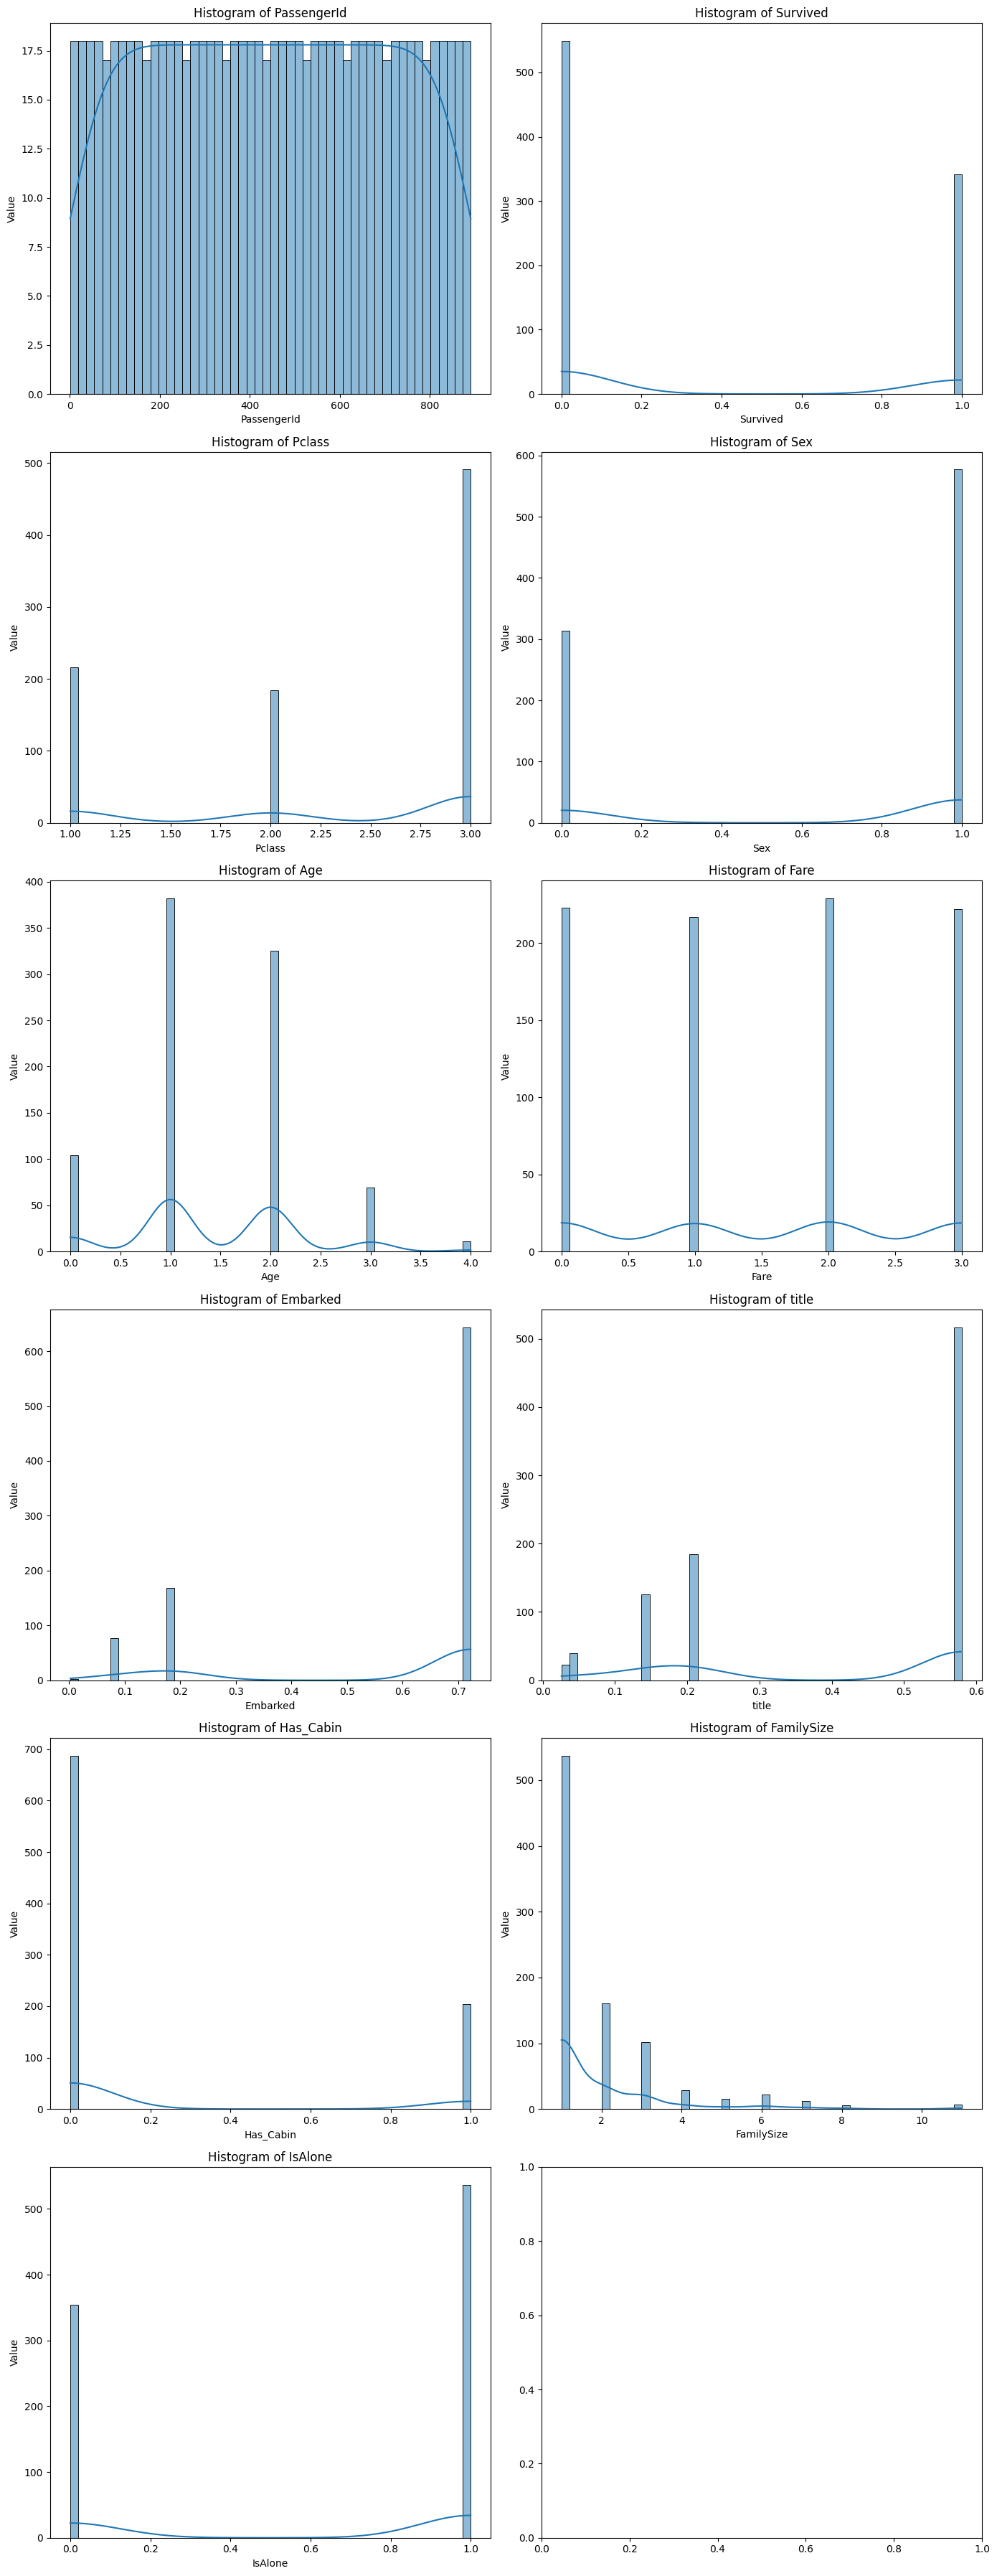

In [13]:
# Set up the figure and axes for subplots
num_cols = len(X.columns)
num_rows = (num_cols + 1) // 2  # Ensure enough rows for all columns
fig, axes = plt.subplots(nrows=num_rows, ncols=2, figsize=(14, 6 * num_rows))

# Iterate through all columns
for i, col in enumerate(X.columns):
    row_idx = i // 2
    col_idx = i % 2
    ax = axes[row_idx, col_idx]

    # Create a histogram for the current column
    sns.histplot(data=X, x=col, bins=50, kde=True, ax=ax)
    ax.set_xlabel(col)
    ax.set_ylabel("Value")
    ax.set_title(f"Histogram of {col}")

    # Calculate skewness for the current column
    skewness = skew(X[col])
    print(f"Skewness {col}:", skewness)

# Adjust layout and spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()

In [14]:
X.drop(columns=["Survived"], inplace=True)

<ipython-input-14-4f682fa155c2>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.drop(columns=["Survived"], inplace=True)


In [15]:
lgbm_params = {
    "verbosity": -1,
    "boosting_type": "gbdt",
    "learning_rate": 0.05,
    "num_leaves": 31,
    "max_depth": -1,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "n_estimators": 1000,
    "seed": 42
}

xgb_params = {
    "verbosity": 0,
    "booster": "gbtree",
    "eta": 0.05,
    "max_depth": None,  # Equivalent to no limit in XGBoost
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "n_estimators": 1000,
    "seed": 42
}

features = [col for col in X.columns if col != "PassengerId"]


In [16]:
X[features]

,Pclass,Sex,Age,Fare,Embarked,title,Has_Cabin,FamilySize,IsAlone
0,3,1,1.0,0,0.722783,0.580247,0,2,0
1,1,0,2.0,3,0.188552,0.141414,1,2,0
2,3,0,1.0,1,0.722783,0.207632,0,1,1
3,1,0,2.0,3,0.722783,0.141414,1,2,0
4,3,1,2.0,1,0.722783,0.580247,0,1,1
...,...,...,...,...,...,...,...,...,...
886,2,1,1.0,1,0.722783,0.025814,0,1,1
887,1,0,1.0,2,0.722783,0.207632,1,1,1
888,3,0,1.0,2,0.722783,0.207632,0,4,0
889,1,1,1.0,2,0.188552,0.580247,1,1,1


Accuracy: 0.84


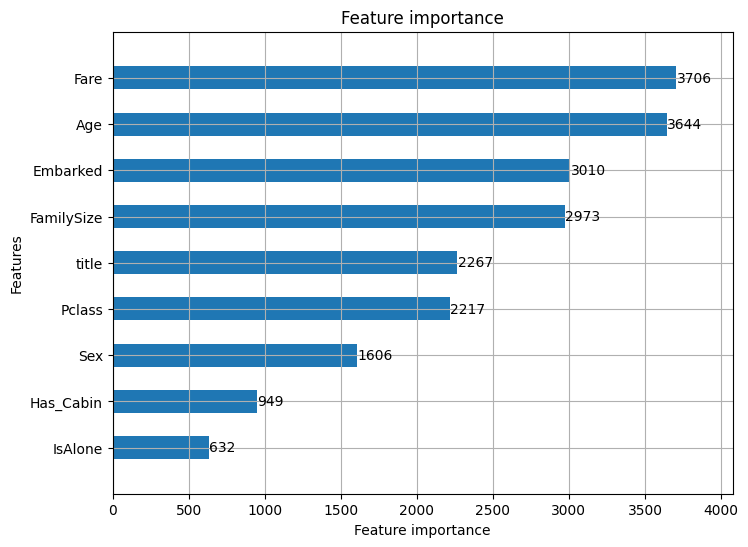

In [17]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X[features], y, test_size=0.1, random_state=42)

# Create a LightGBM classifier
clf = lgb.LGBMClassifier(**lgbm_params)

# Fit the classifier on the training data
clf.fit(X_train, y_train)

# Make predictions on the test data
y_pred = clf.predict(X_test)

# Evaluate the model's accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")


lgb.plot_importance(clf, height=0.5, figsize=(8, 6))
plt.show()

Accuracy: 0.84


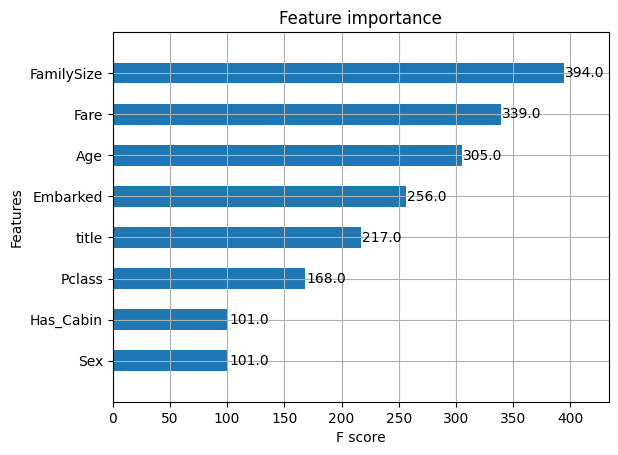

In [18]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X[features], y, test_size=0.1, random_state=42)

# Create an XGBoost classifier
clf = xgb.XGBClassifier()

# Fit the classifier on the training data
clf.fit(X_train, y_train)

# Make predictions on the test data
y_pred = clf.predict(X_test)

# Evaluate the model's accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

xgb.plot_importance(clf, height=0.5)
plt.show()

In [19]:
test_df['Survived'] = clf.predict(test_df[features]).astype(int)
output = pd.DataFrame({'PassengerId': test_df.PassengerId, 'Survived': test_df.Survived})
output.to_csv("my_submission.csv", index=False)

<ipython-input-19-f40b0978ed4a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['Survived'] = clf.predict(test_df[features]).astype(int)


In [20]:
output

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0
